# Load the Data and Initial Packages

In [1]:
import os, numpy as np, pandas as pd, csv, matplotlib.pyplot as plt
from datetime import datetime

######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os, gc, random

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
import sklearn as sk  #scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts #train test split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report as CR #for 2-class model
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.metrics import f1_score as f1

#Tensorflow
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv3D,AveragePooling2D, MaxPooling2D, MaxPooling3D,GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16, ResNet152, EfficientNetB6 as ENETB6
import tensorflow.keras.backend as K #let's write our own metrics and loss functions
from tensorflow.keras.utils import plot_model


#Graphing
import cv2
from PIL import Image
import glob           #helps read files
import matplotlib.pyplot as plt
import graphviz
import pydot_ng as pydot

print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
################################################conda ##############################################################################




[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9506156184636061143
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14236516352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8504444839937214950
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Memory Management

In [2]:
def reset_keras():
    tf.keras.backend.clear_session #This clears the GPU session
    gc.collect()
reset_keras()       

# Data

In [3]:
#Kaggle Data Set
gc
train=pd.read_csv('C:/Users/lfult/Documents/mnist/train.csv')
test=pd.read_csv('C:/Users/lfult/Documents/mnist/test.csv')
trainlab=train['label']
train=train.drop(columns=['label'])

train=train.values.reshape(42000,28,28)
train=train/255
test=test.values.reshape(28000,28,28)
test=test/255

print(train.shape,test.shape)

mysize=32

with tf.device('/GPU:0'):    
    images=[]
    for i in np.arange(len(train)):
        image=train[i,:]
        image=cv2.resize(image,(mysize,mysize))
        image=cv2.merge([image,image,image])        
        images.append(image)

    testimages=[]
    for i in np.arange(len(test)):
        image=test[i,:]
        image=cv2.resize(image,(mysize,mysize))
        image=cv2.merge([image,image,image])        
        testimages.append(image)    


print(np.asarray(images).shape,np.asarray(testimages).shape)



(42000, 28, 28) (28000, 28, 28)
(42000, 32, 32, 3) (28000, 32, 32, 3)


# Look at Images

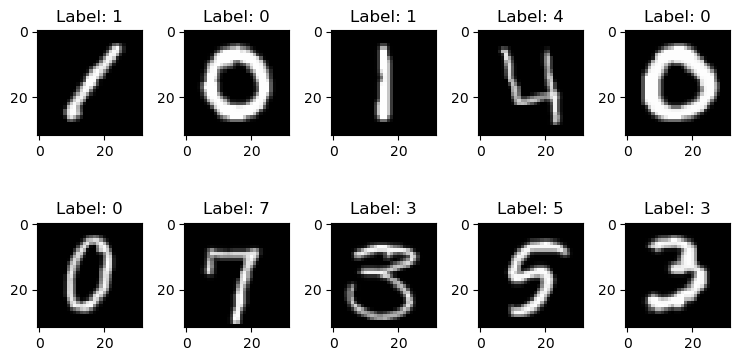

In [4]:
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i])
    ax.set_title('Label: {}'.format(trainlab[i]))
plt.tight_layout()
plt.show()

# CNN

## Model

In [5]:
reset_keras()

input_2=Input(shape=(mysize,mysize,3))
cnn = VGG16(include_top=False)(input_2)
x = Flatten(name='Flatten')(cnn) 
x = Dense(128, activation='relu', name="Dense_128")(x)
x = Dropout(.5, name="Dropout_0.5")(x)
x = Dense(64, activation='relu', name="Dense_64")(x)
x = Dropout(.3, name="Droput_0.3")(x)          
x = Dense(16,activation='relu', name="Dense_16")(x)
x = Dropout(.1, name="Droput_0.1")(x)
output=Dense(10, activation='softmax', name="Final")(x)
model=Model(inputs=[input_2], outputs=output)


# Model Plot

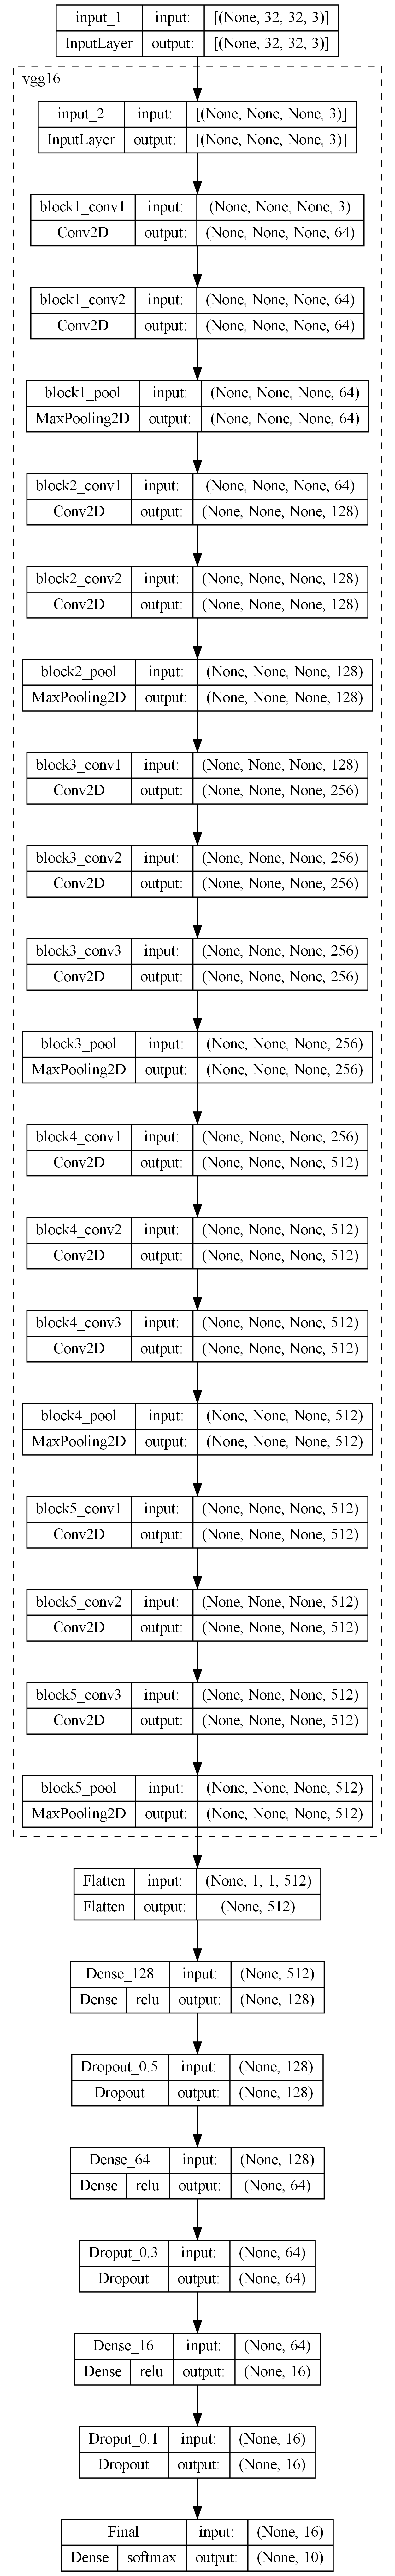

In [6]:
plot_model(model, rankdir='TB',to_file='model_CNN.png', dpi=256, show_shapes=True, show_layer_names=True, expand_nested=True, 
                    show_layer_activations=True)

# Compile and Run

In [14]:
reset_keras()


train=images
test=testimages
train=np.reshape(train,(len(trainlab),mysize,mysize,3))
test=np.reshape(test,(28000,mysize,mysize,3))
batch=3264
numepochs=20 # x 4
tf.config.run_functions_eagerly(False)

with tf.device('/GPU:0'): 
    early = EarlyStopping(monitor='val_loss', mode='min', patience=100,restore_best_weights=True, verbose=2)
    checkpoint = ModelCheckpoint("C:/Users/lfult/Documents/mnist/best_model.hdf5", monitor='accuracy', verbose=1,
        save_best_only=True, mode='auto')
    model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train,trainlab,validation_split=.2,shuffle=True, epochs=numepochs, 
                       batch_size=batch,callbacks=[early,checkpoint])


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.9626
Epoch 1: accuracy improved from -inf to 0.96262, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
11/11 [==============================] - 7s 593ms/step - loss: 0.1279 - accuracy: 0.9626 - val_loss: 0.0392 - val_accuracy: 0.9906
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9637
Epoch 2: accuracy improved from 0.96262 to 0.96366, saving model to C:/Users/lfult/Documents/mnist\best_model.hdf5
11/11 [==============================] - 8s 721ms/step - loss: 0.1217 - accuracy: 0.9637 - val_loss: 0.0489 - val_accuracy: 0.9894
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9634
Epoch 3: accuracy did not improve from 0.96366
11/11 [==============================] - 6s 584ms/step - loss: 0.1275 - accuracy: 0.9634 - val_loss: 0.0404 - val_accuracy: 0.9906
Epoch 4/20
11/11 [==============================] -

# Predictions

In [15]:
pred1=tf.argmax(model.predict(train),1)
pd.crosstab(trainlab, pred1, margins=True)

1313/1313 [==============================] - 7s 5ms/step


col_0,0,1,2,3,4,5,6,7,8,9,All
label,,,,,,,,,,,
0,4118,0,2,0,0,2,5,0,5,0,4132
1,1,4670,2,0,1,0,1,8,1,0,4684
2,1,1,4165,1,0,0,1,3,5,0,4177
3,2,0,4,4330,0,8,0,1,4,2,4351
4,0,2,0,0,4050,0,1,4,2,13,4072
5,0,0,2,3,0,3785,2,0,3,0,3795
6,0,0,0,1,1,8,4126,0,1,0,4137
7,0,3,17,1,2,0,0,4375,2,1,4401
8,2,0,7,4,0,3,2,1,4041,3,4063


# Accuracy

In [16]:
sum(np.diagonal(pd.crosstab(trainlab,pred1)))/42000

0.9953571428571428

# History Plot

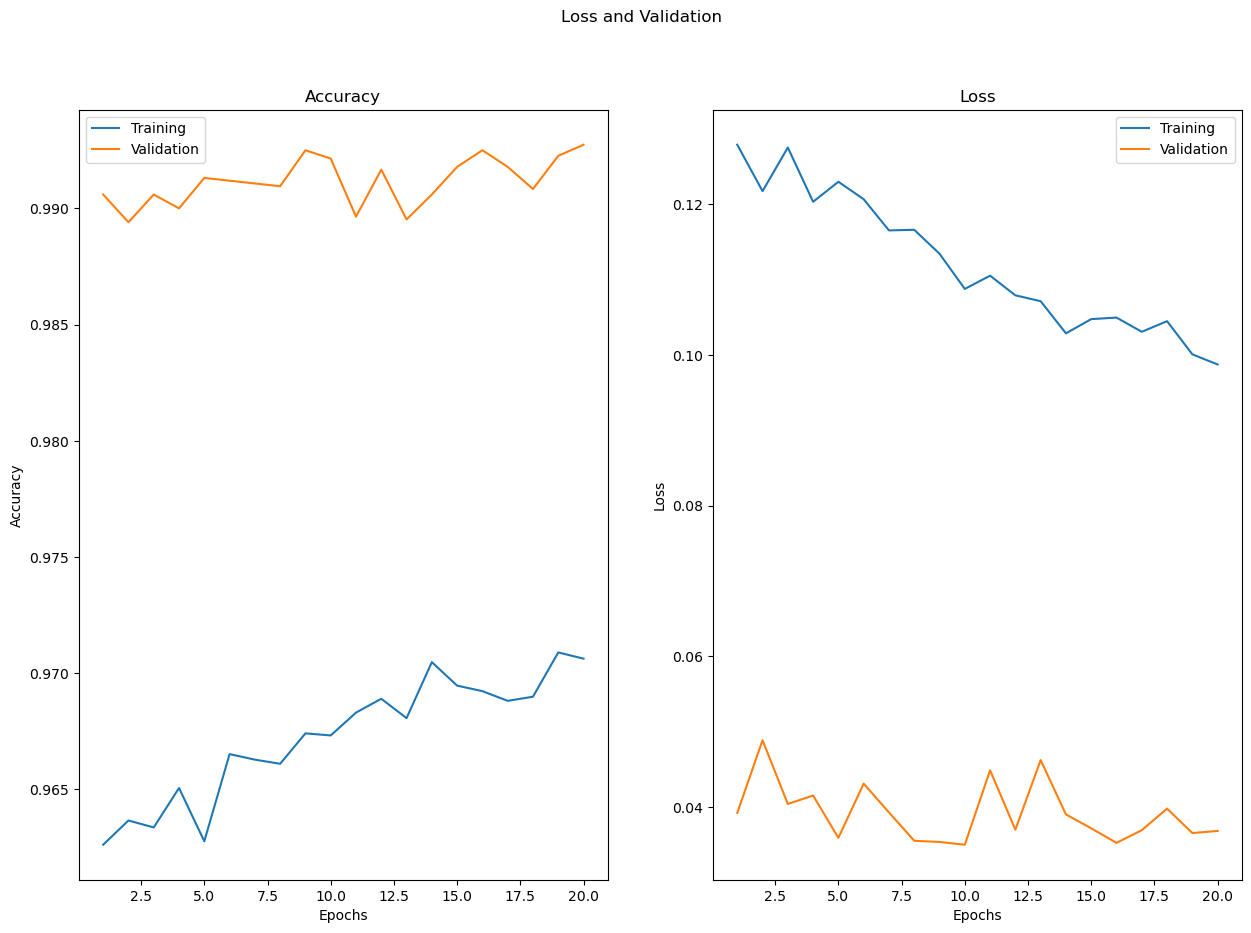

In [17]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss'])

# Write File for Submission

In [11]:
mypred,myseq=tf.argmax(model.predict(test),1),np.arange(1,28001)
d = pd.DataFrame({'ImageId': myseq, 'Label': mypred}).to_csv("C:/Users/lfult/Documents/mnist/forsubmit1.csv", index=False)

875/875 [==============================] - 5s 5ms/step
